Instructions to run the notebook may be found in `README.md`.

# Imports

In [2]:
# Magics
%matplotlib inline
%config InlineBackend.figure_format = "retina"  # Higher resolution plots

In [94]:
# Imports
import os
import pathlib
import warnings
from typing import Optional, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import yaml
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImPipeline
from IPython.core.interactiveshell import InteractiveShell
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBClassifier

import features
import model_eval_plots

In [6]:
# Configs
InteractiveShell.ast_node_interactivity = "all"  # Multiple outputs allowed
plt.style.use("material_theme_light.mplstyle")
shap.initjs()

## Loading data

Data is loaded into a Pandas DataFrame. Four columns—`transactionDateTime`, `currentExpDate`, `accountOpenDate`, and
`dateOfLastAddressChange`— are identified as dates or times and are converted accordingly. Blank strings (`""`) are
found in multiple columns such as `merchantState` and `merchantZip`. Those blank strings are treated as missing
values and are replaced with `NaN`.

In [95]:
# Peek at data
!head -2 data/raw/transactions.txt

{"accountNumber": "733493772", "customerId": "733493772", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-01-08T19:04:50", "transactionAmount": 111.33, "merchantName": "Lyft", "acqCountry": "US", "merchantCountryCode": "US", "posEntryMode": "05", "posConditionCode": "01", "merchantCategoryCode": "rideshare", "currentExpDate": "04/2020", "accountOpenDate": "2014-08-03", "dateOfLastAddressChange": "2014-08-03", "cardCVV": "492", "enteredCVV": "492", "cardLast4Digits": "9184", "transactionType": "PURCHASE", "isFraud": true, "echoBuffer": "", "currentBalance": 0.0, "merchantCity": "", "merchantState": "", "merchantZip": "", "cardPresent": false, "posOnPremises": "", "recurringAuthInd": "", "expirationDateKeyInMatch": false}
{"accountNumber": "733493772", "customerId": "733493772", "creditLimit": 5000.0, "availableMoney": 4888.67, "currentBalance": 111.33, "transactionDateTime": "2016-01-09T22:32:39", "transactionAmount": 24.75, "merchantName": "Uber", "acqCoun

In [7]:
# Look for date columns
!head -1 data/raw/transactions.txt | grep -i "date"

{"accountNumber": "733493772", "customerId": "733493772", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-01-08T19:04:50", "transactionAmount": 111.33, "merchantName": "Lyft", "acqCountry": "US", "merchantCountryCode": "US", "posEntryMode": "05", "posConditionCode": "01", "merchantCategoryCode": "rideshare", "currentExpDate": "04/2020", "accountOpenDate": "2014-08-03", "dateOfLastAddressChange": "2014-08-03", "cardCVV": "492", "enteredCVV": "492", "cardLast4Digits": "9184", "transactionType": "PURCHASE", "isFraud": true, "echoBuffer": "", "currentBalance": 0.0, "merchantCity": "", "merchantState": "", "merchantZip": "", "cardPresent": false, "posOnPremises": "", "recurringAuthInd": "", "expirationDateKeyInMatch": false}


In [7]:
# Read data in while converting all columns identified in the previous
# cell to dates (besides expirationDateKeyInMatch, which is a bool)
transactions = pd.read_json(
    pathlib.Path("data/raw/transactions.txt"),
    orient="records",
    lines=True,
    convert_dates=[
        "transactionDateTime",
        "currentExpDate",
        "accountOpenDate",
        "dateOfLastAddressChange",
    ],
)

In [8]:
# Label blank strings as missing values
transactions = transactions.replace("", np.nan)

In [9]:
# Peek at loaded data
transactions.head()

accountNumber  customerId  creditLimit  availableMoney transactionDateTime  \
0      733493772   733493772         5000         5000.00 2016-01-08 19:04:50   
1      733493772   733493772         5000         4888.67 2016-01-09 22:32:39   
2      733493772   733493772         5000         4863.92 2016-01-11 13:36:55   
3      733493772   733493772         5000         4676.52 2016-01-11 22:47:46   
4      733493772   733493772         5000         4449.18 2016-01-16 01:41:11   

   transactionAmount merchantName acqCountry merchantCountryCode posEntryMode  \
0             111.33         Lyft         US                  US           05   
1              24.75         Uber         US                  US           09   
2             187.40         Lyft         US                  US           05   
3             227.34         Lyft         US                  US           02   
4               0.00         Lyft         US                  US           02   

   ... isFraud echoBuffer currentBalance merchantCity merchantState  \
0  ...    True        NaN           0.00          NaN           NaN   
1  ...   False        NaN         111.33          NaN           NaN   
2  ...   False        NaN         136.08          NaN           NaN   
3  ...    True        NaN         323.48          NaN           NaN   
4  ...   False        NaN         550.82          NaN           NaN   

   merchantZip  cardPresent  posOnPremises recurringAuthInd  \
0          NaN        False            NaN              NaN   
1          NaN        False            NaN              NaN   
2          NaN        False            NaN              NaN   
3          NaN        False            NaN              NaN   
4          NaN        False            NaN              NaN   

   expirationDateKeyInMatch  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  

[5 rows x 29 columns]

The data contains 641,914 records, each containing 29 fields—six of which are empty.

In [10]:
# Number of records and fields
transactions.shape

(641914, 29)

In [11]:
# Get number of empty columns
(transactions.count() == 0).sum()

6

The minimum and maximum values—along with other accompanying summary statistics—are provided for date and numerical columns that are not ids. Unique values are provided for categorical data where the number of unique values is found to be less than 100.

In [12]:
# Get all empty columns to ignore
empty_columns = transactions.columns[transactions.count() == 0].tolist()

# Numerical columns that are categorical
categorical_num_columns = [
    "accountNumber",
    "customerId",
    "cardLast4Digits",
    "cardCVV",
    "enteredCVV",
]

# Get all numerical columns, excluding ids and empty columns
numerical_columns = (
    transactions.select_dtypes(include=[int, float])
    .drop(columns=categorical_num_columns + empty_columns)
    .columns
)

In [13]:
# Minimum and maximum for numerical columns
transactions[numerical_columns].describe()

creditLimit  availableMoney  transactionAmount  currentBalance
count  641914.000000   641914.000000      641914.000000   641914.000000
mean    10697.210608     6652.828573         135.162497     4044.382035
std     11460.359133     9227.132275         147.053302     5945.510224
min       250.000000    -1244.930000           0.000000        0.000000
25%      5000.000000     1114.970000          32.320000      502.442500
50%      7500.000000     3578.165000          85.800000     2151.860000
75%     15000.000000     8169.185000         189.030000     5005.890000
max     50000.000000    50000.000000        1825.250000    47496.500000

In [14]:
# Min and maximum for datetime columns
transactions.describe(include=["datetime"])

transactionDateTime       currentExpDate      accountOpenDate  \
count                641914               641914               641914   
unique               635472                  165                 1826   
top     2016-01-11 00:34:57  2026-05-01 00:00:00  2015-12-11 00:00:00   
freq                      3                 4209                10137   
first   2016-01-01 00:00:37  2018-05-01 00:00:00  1985-12-25 00:00:00   
last    2016-12-30 23:59:27  2032-01-01 00:00:00  2015-12-31 00:00:00   

       dateOfLastAddressChange  
count                   641914  
unique                    2186  
top        2016-07-20 00:00:00  
freq                      3948  
first      1985-12-25 00:00:00  
last       2016-12-30 00:00:00

In [104]:
# Count of null values per column
transactions.isna().sum().sort_values(ascending=False).reset_index(
    name="number_of_nulls"
).rename(columns={"index": "column_name"})

column_name  number_of_nulls
0              posOnPremises           641914
1                merchantZip           641914
2              merchantState           641914
3               merchantCity           641914
4                 echoBuffer           641914
5           recurringAuthInd           641914
6                 acqCountry             3913
7               posEntryMode             3345
8        merchantCountryCode              624
9            transactionType              589
10          posConditionCode              287
11              merchantName                0
12  expirationDateKeyInMatch                0
13         transactionAmount                0
14       transactionDateTime                0
15               creditLimit                0
16                customerId                0
17            availableMoney                0
18   dateOfLastAddressChange                0
19      merchantCategoryCode                0
20            currentExpDate                0
21           accountOpenDate                0
22                   cardCVV                0
23                enteredCVV                0
24           cardLast4Digits                0
25                   isFraud                0
26            currentBalance                0
27               cardPresent                0
28             accountNumber                0

In [105]:
# Number of unique values

# For boolean columns
for column in transactions.select_dtypes(bool).columns:
    print("\n")
    print(column)
    print("-----")
    transactions[column].unique()

# For string columns, if number of unique values is less than 100
for column in transactions.select_dtypes(object).columns:
    unique_vals = transactions[column].unique()
    if unique_vals.shape[0] < 100:
        print("\n")
        print(column)
        print("---------")
        unique_vals

# For specific numerical columns
for column in ("creditLimit",):
    print("\n")
    print(column)
    print("---------")
    transactions[column].unique()



isFraud
-----


array([ True, False])



cardPresent
-----


array([False,  True])



expirationDateKeyInMatch
-----


array([False,  True])



acqCountry
---------


array(['US', nan, 'PR', 'MEX', 'CAN'], dtype=object)



merchantCountryCode
---------


array(['US', 'PR', 'MEX', nan, 'CAN'], dtype=object)



posEntryMode
---------


array(['05', '09', '02', '90', nan, '80'], dtype=object)



posConditionCode
---------


array(['01', '08', '99', nan], dtype=object)



merchantCategoryCode
---------


array(['rideshare', 'online_gifts', 'personal care', 'fastfood',
       'entertainment', 'online_subscriptions', 'mobileapps', 'fuel',
       'food', 'online_retail', 'airline', 'hotels', 'food_delivery',
       'cable/phone', 'subscriptions', 'auto', 'gym', 'furniture',
       'health'], dtype=object)



transactionType
---------


array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)



creditLimit
---------


array([ 5000,  7500,   250, 20000,   500, 50000,  2500, 15000,  1000,
       10000])

### Definitions of columns

`posEntryMode` – A code that identifies the method used to capture the account number and expiration date. [Reference table](https://dnwebdomestic2.efunds.com/dnweb/webhelp/Field_Descriptions/MC_POS_Entry_Mode.htm)

`posConditionCode` – Indicates transaction conditions at the point of sale or service.

`acqCountry` – Acquirer country?

`creditLimit` – Should be the sum of `availableMoney` and `currentBalance`

## Plotting transaction amounts

A histogram of the processed amounts of each transaction, the `transactionAmount` column.

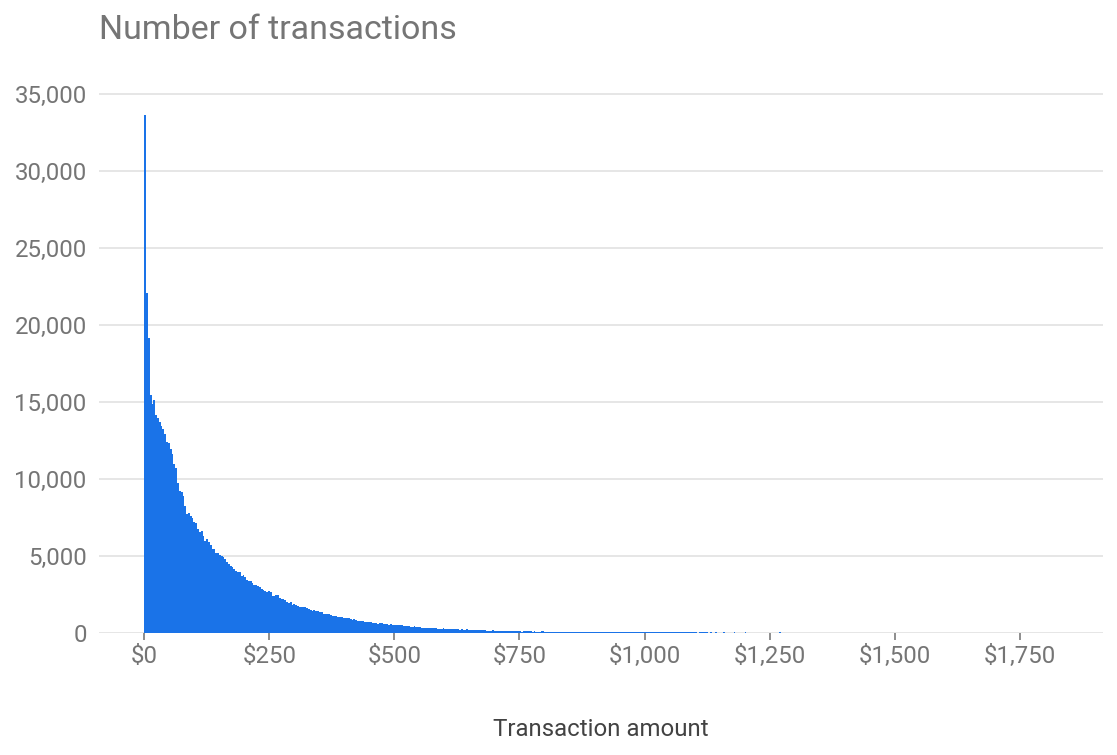

In [96]:
ax = transactions["transactionAmount"].hist(bins=502)
ax.set_title("Number of transactions", loc="left")
ax.set_xlabel("Transaction amount")
ax.xaxis.grid(False)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("${x:,.0f}"))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", which="major", bottom=True);

The distribution is highly skewed right. The first bin is the largest, with over 5% of transactions being under $3.64. As expected, a large majority of transactions are lower cost. High transaction amount could be one indicator of potential fraudulent activity.

In [23]:
# Peek at amount in each bin
pd.cut(transactions["transactionAmount"], bins=502).value_counts(
    sort=False
).reset_index(name="count").rename(columns={"index": "bin"})

bin  count
0         (-1.825, 3.636]  33626
1          (3.636, 7.272]  22079
2         (7.272, 10.908]  19129
3        (10.908, 14.544]  15432
4         (14.544, 18.18]  14837
..                    ...    ...
497   (1807.07, 1810.706]      0
498  (1810.706, 1814.342]      0
499  (1814.342, 1817.978]      0
500  (1817.978, 1821.614]      0
501   (1821.614, 1825.25]      1

[502 rows x 2 columns]

In [24]:
# Find the 80th percentile amount
transactions["transactionAmount"].quantile(0.80)

222.48

## Identifying duplicate transactions

Transactions are given IDs. Two arrays below—`multi_swipe_transaction_ids` and `reversal_transaction_ids`—identify multi-swip and reversal transactions, respectively.

I am assuming that the columns listed in `transaction_id_columns` below may be used to uniquely identify a transaction. These columns will be used to pair up duplicate transactions to identify them as either multi-swipe or reversed transactions.

In [16]:
# Columns chosen to identify the transaction
transaction_id_columns = [
    "accountNumber",
    "customerId",
    "creditLimit",
    "transactionAmount",
    "merchantName",
    "acqCountry",
    "merchantCountryCode",
    "posEntryMode",
    "posConditionCode",
    "merchantCategoryCode",
    "accountOpenDate",
    "cardCVV",
    "enteredCVV",
    "cardLast4Digits",
]

# Sort date columns for use in ``merge_asof``
transactions = transactions.sort_values("transactionDateTime")

# Create an id to identify each transaction from the index
transactions["transaction_id"] = transactions.reset_index()["index"]

The "merchantName" column has some values that contain a code following the actual name—such as "AMC #606218". I removed the code and left the name.

In [17]:
transactions[transactions["merchantName"].str.contains("#")]["merchantName"].head(10)

386379              AMC #606218
529558           Subway #138388
22806       Dairy Queen #421133
90564         Franks Pub #86033
62444      Regal Cinemas #05791
111903     EZ Putt Putt #551896
592890    Hilton Hotels #147997
337222        Taco Bell #715722
148150        Best Deli #316476
618871              AMC #692956
Name: merchantName, dtype: object

In [18]:
# Remove trailing codes from merchantName
transactions["merchantName"] = transactions["merchantName"].str.split(" #").str[0]

### Multi-swipe

In [19]:
# For all transactions, find if another transactions exists in the table
# that has all the same values for the columns specified in
# ``transaction_id_columns``--but occurs within 12 hours after the
# original transaction date
similar_transactions = pd.merge_asof(
    left=transactions,
    right=transactions,
    on="transactionDateTime",
    by=transaction_id_columns + ["transactionType"],
    tolerance=pd.Timedelta("12 hours"),
    allow_exact_matches=False,
    direction="forward",
    suffixes=["_before", "_after"],
)

# Remove transactions that get no match and grab the ids of the
# multi-swipe transactions
similar_transactions = similar_transactions[
    ~similar_transactions["transaction_id_after"].isna()
]
multi_swipe_transaction_ids = similar_transactions["transaction_id_after"]

# Count number of multi-swipes and sum up their balances
total_multi_swipes = similar_transactions.shape[0]
total_multi_swipe_balance = similar_transactions["transactionAmount"].sum()

# Remove transactions flagged as multi-swipes
non_multi_swipe_transactions = transactions[
    ~transactions["transaction_id"].isin(multi_swipe_transaction_ids)
]

# Store transactions that were multi-swiped for later use
with open(pathlib.Path("data/features/multi_swipe_ids.yaml"), mode="w") as file:
    file.write(yaml.safe_dump(similar_transactions["transaction_id_before"].tolist()))

54660

In [21]:
similar_transactions.shape

(6190, 44)

The above code purposefully ignores cases where the date is an exact match.
Manually check for similar transactions with the exact same `transactionDateTime`.

In [22]:
# Find identical transactions that occur at the exact same time
identical_transactions = non_multi_swipe_transactions.merge(
    non_multi_swipe_transactions,
    on=transaction_id_columns + ["transactionType", "transactionDateTime"],
    suffixes=["_before", "_after"],
)

# Return the number of identical tranactions with identical times
# Filter out cases where transaction matches with itself
identical_transactions[
    identical_transactions["transaction_id_after"]
    != identical_transactions["transaction_id_before"]
].shape[0]

0

### Reversed

In [23]:
# Create 2 DataFrames--one without reversals, and one that is exclusively
# reversals
non_reversal_transactions = transactions[transactions["transactionType"] != "REVERSAL"]
reversal_transactions = transactions[transactions["transactionType"] == "REVERSAL"]

# Pair up reverals with their most similar transactions
# For each reversal, match it a similar non-reversal transactions and
# choose the transaction that happened most recently
paired_reversal_transactions = pd.merge_asof(
    left=reversal_transactions,
    right=non_reversal_transactions,
    on="transactionDateTime",
    by=transaction_id_columns,
    allow_exact_matches=True,
    direction="backward",
    suffixes=["_reversal", "_actual"],
)

# Remove transactions that did not find a match
# Grab the ids of transactions that have been reversed
paired_reversal_transactions = paired_reversal_transactions[
    ~paired_reversal_transactions["transaction_id_actual"].isna()
]
reversal_transaction_ids = paired_reversal_transactions["transaction_id_actual"]

# Count number of reversed transactions and sum up their balances
total_reversals = paired_reversal_transactions.shape[0]
total_reversal_balance = paired_reversal_transactions["transactionAmount"].sum()

# Store transactions that were reversed for later use
with open(pathlib.Path("data/features/reversed_ids.yaml"), mode="w") as file:
    file.write(yaml.safe_dump(reversal_transaction_ids.tolist()))

158064

As seen in the two following plots, it can be seen that neither multi-swipe or
reversed transactions occur in a few `merchantCategoryCode` values—`fuel`,
`mobileapps`, `online_subscriptions`, `food_delivery`, `gym`, and `cable/phone`.

In [36]:
# Define function to plot out distribution differences between
# multi-swipe, reversal, and all transactions
def plot_comparision_bar(
    subject_ids: np.array,
    category_name: str,
    id_name: str,
    plot_title: str = "",
    limit: Optional[int] = None,
) -> mpl.axes._axes:
    """
    Compare a category distribution for the given IDs to that of all transactions.

    Parameters
    ----------
    subject_ids : np.array
        A NumPy array of the IDs of interest.
    category_name : str
        Name of column to plot against.
    id_name : str
        Name for group of ids submitted in ``subject_ids``.
    plot_title : str, optional
        Title to be assigned to plot. Blank by default.
    limit : int, optional
        Limit the amount of categories in the plot. By default will plot
        the counts of every category in the specified column.

    Returns
    -------
    ax : matplotlib Axes
        Returns the plot drawn onto the Axes.
    """
    # Get the counts of all category values for the inputted
    # ``subject_ids``
    subject_categories = (
        non_reversal_transactions[
            (non_reversal_transactions["transaction_id"].isin(subject_ids))
        ][category_name]
        .value_counts(normalize=True)[:limit]
        .reset_index(name="transaction_share")
        .rename(columns={"index": category_name})
    )
    subject_categories["transaction_type"] = id_name

    # Get the counts of all category values for all non-reversal
    # transactions
    all_transaction_categories = (
        non_reversal_transactions[category_name]
        .value_counts(normalize=True)[:limit]
        .reset_index(name="transaction_share")
        .rename(columns={"index": category_name})
    )
    all_transaction_categories["transaction_type"] = "All transactions"

    # Draw a bar plot comparing the two distributions
    ax = sns.barplot(
        data=pd.concat([subject_categories, all_transaction_categories]),
        y=category_name,
        x="transaction_share",
        hue="transaction_type",
    )
    ax.set_title(plot_title, loc="left")
    ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
    ax.axvline(0, c="#9E9E9E", zorder=1)
    ax.xaxis.grid(True)
    return ax

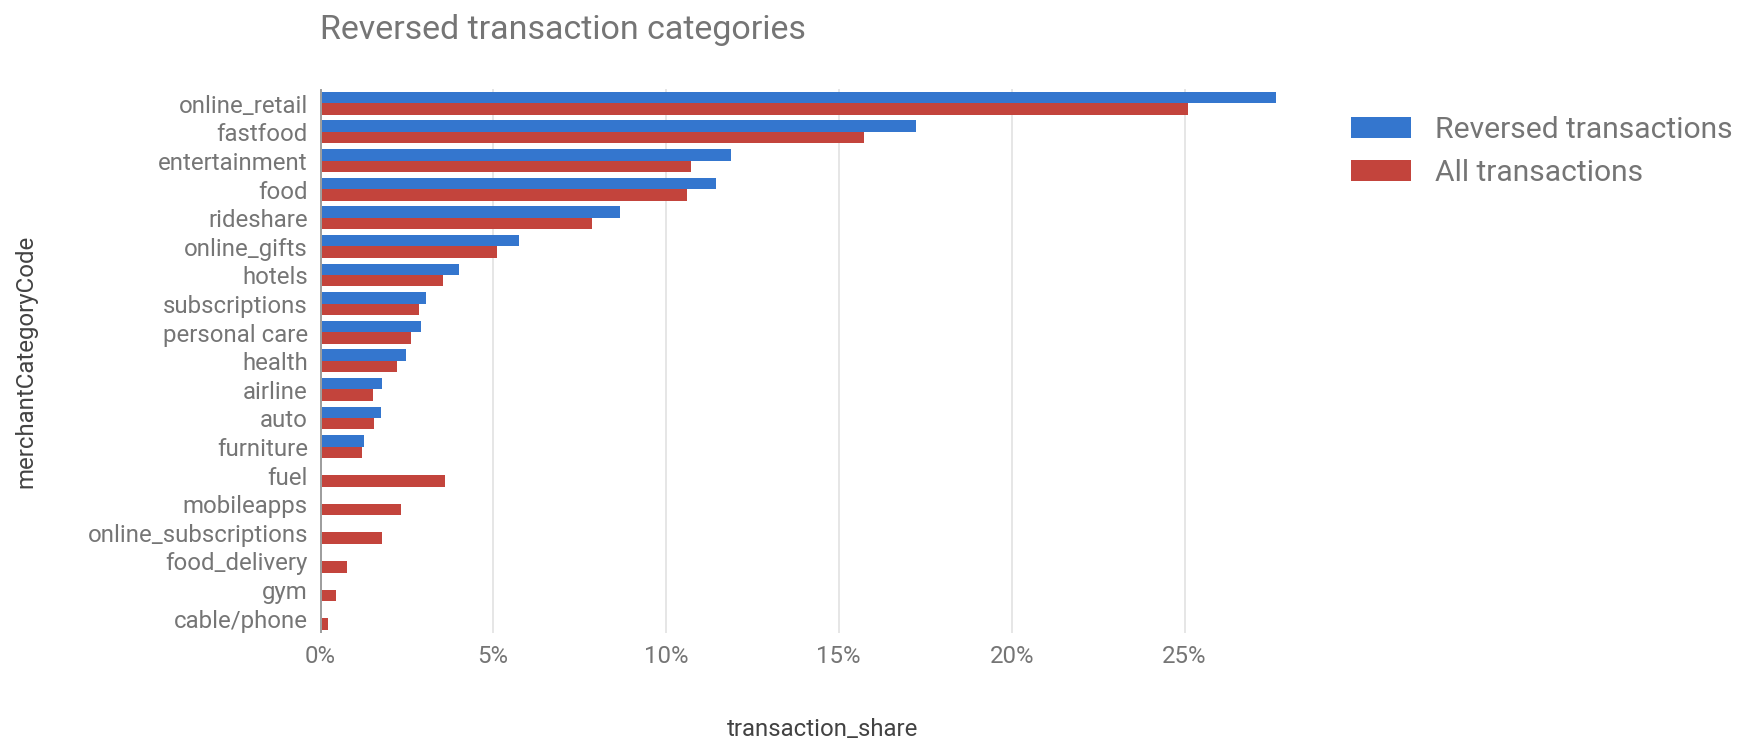

In [99]:
# Plot distribution comparison of merchantCategoryCode for reversals
plot_comparision_bar(
    reversal_transaction_ids,
    id_name="Reversed transactions",
    category_name="merchantCategoryCode",
    plot_title="Reversed transaction categories",
);

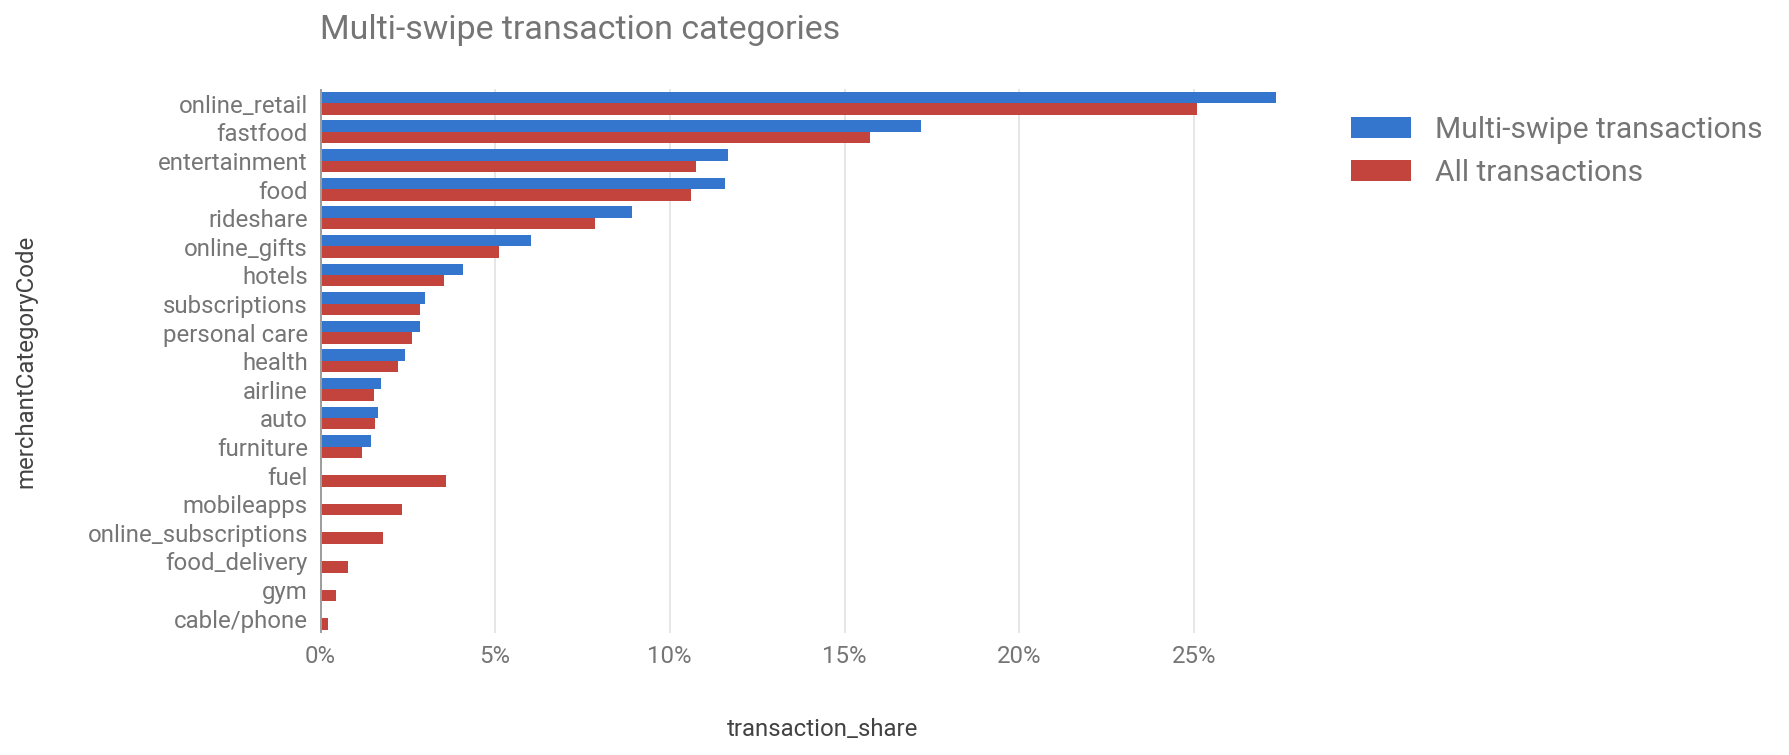

In [100]:
# Plot distribution comparison of merchantCategoryCode for multi-swipe
plot_comparision_bar(
    multi_swipe_transaction_ids,
    id_name="Multi-swipe transactions",
    category_name="merchantCategoryCode",
    plot_title="Multi-swipe transaction categories",
);

Estimated shares are displayed in the table below.

In [39]:
# Get the total transaction amount and number of transactions
# Exclude reversals
total_transaction_balance = non_reversal_transactions["transactionAmount"].sum()
number_of_transactions = non_reversal_transactions.shape[0]

In [40]:
# Return the number of reversals that are multi-swipes
np.intersect1d(
    reversal_transaction_ids.values, multi_swipe_transaction_ids.values
).shape[0]

127

It is natural to assume that many multi-swipes are eventually reversed. The code above shows that there is some overlap between reversal transactions and multi-swipe transactions. Therefore, we will count the total number of transactions and balances for the combined totals separately—as to not double count.

In [41]:
# Get totals for both multi-swipe and reversals
multi_swipe_and_reversal_transactions = transactions[
    transactions["transaction_id"].isin(reversal_transaction_ids)
    | transactions["transaction_id"].isin(multi_swipe_transaction_ids.values)
]
total_combined_balance = multi_swipe_and_reversal_transactions[
    "transactionAmount"
].sum()
total_combined = multi_swipe_and_reversal_transactions.shape[0]

In [42]:
# Create table
all_total_balances = [
    total_multi_swipe_balance,
    total_reversal_balance,
    total_combined_balance,
]
all_total_counts = [total_multi_swipes, total_reversals, total_combined]
overlap_report = pd.DataFrame(
    data={
        "total_balance": all_total_balances,
        "number_of_transactions": all_total_counts,
        "total_balance_proportion": [
            balance / total_transaction_balance for balance in all_total_balances
        ],
        "number_of_transactions_proportion": [
            count / number_of_transactions for count in all_total_counts
        ],
    },
    index=["multi_swipes", "reversals", "combined"],
)
overlap_report

total_balance  number_of_transactions  total_balance_proportion  \
multi_swipes      888131.91                    6190                  0.010508   
reversals        2121434.38                   14604                  0.025100   
combined         2993252.39                   20667                  0.035415   

              number_of_transactions_proportion  
multi_swipes                           0.009892  
reversals                              0.023338  
combined                               0.033027

## Creating a model to detect fraud

One assumption I will be making is that fraud may be caught retroactively. I will be including features that indicate if the transaction was eventually reversed or if it is a multi-swipe. Both—especially the reversal—may happen some time after the initial charge occurs.

### Clean data

In order to remove duplicate transactions, I will be excluding all reversal transactions and removing the multi-swipe transactions identified earlier. In both cases I will be retaining the original transactions.

In [43]:
# Make dataset without reversal or multi-swipe transactions
clean_transactions = non_reversal_transactions[
    ~non_reversal_transactions["transaction_id"].isin(multi_swipe_transaction_ids)
]

# Remove empty columns
clean_transactions = clean_transactions.drop(columns=empty_columns)

In [44]:
# Export for later use
clean_transactions.to_csv(
    pathlib.Path("data/cleaned/clean_transactions.csv"), index=False
)

### Engineered features

Engineered features are listed as individual functions in the file [`features.py`](features.py). The function `create_features()` runs all the feature functions and outputs them as CSV files.

The features engineered are:

- Is the transaction a multi-swipe?
- Is the transaction reversed?
- Was the "cardCVV" equal to the "enteredCVV"?
- Seconds since account was last involved in a transaction
- Day of the week the transaction occurred
- Month the transaction occurs
- If the transaction occurs on a US holiday
- If acqCountry equals merchantCountryCode
- Seconds since address was changed
- If transaction has a "special" merchantCategoryCode
    - Special categories are: `fuel`, `mobileapps`, `online_subscriptions`, `food_delivery`, `gym`, and `cable/phone`
- availableMoney divided by creditLimit
- transactionAmount column divided by availableMoney
- transactionAmount column divided by creditLimit
- currentBalance column divided by creditLimit
- transactionAmount column divided by availableMoney
- Seconds until expiration
- Seconds until account opens
- If transaction is the account's first
- If acqCountry is equal to that of the account's previous transaction
- If merchantCountryCode is equal to the account's previous transaction.


In [45]:
# Read in data
clean_transactions = pd.read_csv(
    "data/cleaned/clean_transactions.csv",
    parse_dates=[
        "transactionDateTime",
        "currentExpDate",
        "accountOpenDate",
        "dateOfLastAddressChange",
    ],
)

In [46]:
# Create all features listed in ``features.py``
features.create_features(clean_transactions)

In [47]:
def fetch_features(
    directory: Union[str, pathlib.Path], data: pd.DataFrame, merge_column: str
) -> pd.DataFrame:
    """
    Merge in features stored in CSV in a directory.

    Assumes files all have one common column name to merge on, and that
    each file has no duplicate values in that column.

    Parameters
    ----------
    directory : Union[str, pathlib.Path]
        The directory where the feature CSV files are stored.
    data : pd.DataFrame
        The data which the features will be merged into.
    merge_column : str
        The name of the column to merge on. The DataFrame and each file
        must contain this column.

    Returns
    -------
    data_features : pd.DataFrame
        The original data with all features merged in.
    """
    data = data.copy()
    original_number_of_rows = data.shape[0]
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            print(filename)
            feature = pd.read_csv(os.path.join(directory, filename))
            data = data.merge(feature, on=merge_column, how="left")
            if data.shape[0] != original_number_of_rows:
                raise ValueError(
                    "A CSV file in the listed directory has duplicate values for"
                    " the column listed in merge_column"
                )
            if "Unnamed" in data.columns:
                warnings.warn("A column is unnamed")
    return data

In [48]:
transaction_features = fetch_features(
    pathlib.Path("data/features/"),
    data=clean_transactions,
    merge_column="transaction_id",
)

is_same_merchantCountryCode_as_prior.csv
seconds_until_expiration.csv
seconds_since_address_change.csv
transaction_month.csv
currentBalance_over_creditLimit.csv
is_first_account_transaction.csv
transactionAmount_over_availableMoney.csv
is_reversed.csv
is_same_acqCountry_as_prior.csv
is_special_merchantCategoryCode.csv
transaction_on_us_holiday.csv
availableMoney_over_creditLimit.csv
seconds_since_account_opened.csv
is_multi_swipe.csv
transactionAmount_over_creditLimit.csv
transaction_day_of_week.csv
seconds_since_account_transaction.csv
currentBalanceover_availableMoney.csv
is_cross_country_transaction.csv
is_correct_cvv.csv


### Missing values/pipeline

Of the remaining columns, five have missing values (not counting "seconds_since_account_transaction"—a generated feature).

The following are my strategies for dealing with the missing values per column:

- **merchantCountryCode** is already overwhelmingly "US", so missing values will be filled in with "US".
- **acqCountry** is found to usually be the same as the country found in "merchantCountryCode". If
    **merchantCountryCode** is available, use it. The class `AcqCountryImputer` was written to handle this case.
- **transactionType** is highly correlated to "transactionAmount". For all recorded cases, if the "transactionType" is "ADDRESS_VERIFICATION", then the "transactionAmount" is found to be 0.00. So if the "transactionAmount" value is 0.00, then it is assumed the "transactionType" to be "ADDRESS_VERIFICATION". If not, it will be set to "PURCHASE". The class `TransactionTypeImputer` was written to handle this case.
- **posEntryMode** and **posConditionCode** will each be filled with their most popular codes

Once all missing values are filled, categorical values are one hot encoded.

As seen below, 99% of "merchantCountryCode" values are "US". Missing values in the column will be automatically filled with "US"

In [49]:
# Look at distribution of countries in "merchantCountryCode"
transaction_features["merchantCountryCode"].value_counts(normalize=True).reset_index(
    name="proportion"
)

index  proportion
0    US    0.991087
1   MEX    0.004118
2   CAN    0.002924
3    PR    0.001871

The table above shows that most "acqCountry" values match their corresponding "merchantCountryCode". When available, missing "acqCountry" values will be set equal to "merchantCountryCode" values.

In [50]:
# Look at counts of pairs of countries involved in a transaction
transaction_features.groupby(["acqCountry", "merchantCountryCode"])[
    "transaction_id"
].count().reset_index(name="number_of_transactions")

acqCountry merchantCountryCode  number_of_transactions
0        CAN                 CAN                    1792
1        CAN                  US                      13
2        MEX                 MEX                    2529
3        MEX                  US                      10
4         PR                  PR                    1150
5         PR                  US                       9
6         US                 CAN                       9
7         US                 MEX                       9
8         US                  PR                       6
9         US                  US                  610257

In [52]:
# Create imputer for "acqCountry"
class AcqCountryImputer(BaseEstimator, TransformerMixin):
    """
    Fill in missing acqCountry values with merchantCountryCode value.

    If merchantCountryCode is also missing, fill in with most frequent
    value.
    """

    def __init__(self):
        self.most_frequent_country = None

    def fit(self, X: pd.DataFrame, y=None):
        """
        Record the most frequent value in the acqCountry column.

        Returns
        -------
        self : AcqCountryImputer
        """
        self.most_frequent_country = X["acqCountry"].mode().loc[0]
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        """
        Impute all missing acqCountry values on X.

        Returns
        -------
        X : np.ndarray
            Data with missing acqCountry values imputed.
        """
        X = X.copy()
        X.loc[
            (~X["merchantCountryCode"].isna()) & (X["acqCountry"].isna()), "acqCountry"
        ] = X[(~X["merchantCountryCode"].isna()) & (X["acqCountry"].isna())][
            "merchantCountryCode"
        ]

        # For all remaining missing values, fill in with most frequent
        # value
        X["acqCountry"] = X["acqCountry"].fillna(self.most_frequent_country)
        return X[["acqCountry"]].values

All transactions with a "transactionType" value of "ADDRESS_VERIFICATION" have a "transactionAmount" of $0.00. If there is no "transactionAmount", then the "transactionType" is assumed to be "ADDRESS_VERIFICATION", else it will be assumed to be "PURCHASE".

In [53]:
# Find the total transaction amount for address verification transaction types
transaction_features[transaction_features["transactionType"] == "ADDRESS_VERIFICATION"][
    "transactionAmount"
].sum()

0.0

In [54]:
# Create imputer for "transactionType"
class TransactionTypeImputer(BaseEstimator, TransformerMixin):
    """
    Fill in missing transactionType values using transactionAmount.

    If transactionAmount is 0, fill in missing transactionAmount with
    "ADDRESS_VERIFICATION". Else fill with "PURCHASE".
    """

    def fit(self, X: pd.DataFrame, y=None):
        """Pass the transformer through."""
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        """
        Impute all missing transactionType values on X.

        Returns
        -------
        X : np.ndarray
            Data with missing transactionType values imputed.
        """
        X = X.copy()
        X.loc[
            (["transactionAmount"] == 0) & (X["transactionType"].isna()),
            "transactionType",
        ] = "ADDRESS_VERIFICATION"

        # For all remaining missing values, fill in with "PURCHASE"
        X["transactionType"] = X["transactionType"].fillna("PURCHASE")
        return X[["transactionType"]].values

In [55]:
# Create pipeline applying different imputation strategies to
# their respective columns
impute_missing_categorical_pipe = ColumnTransformer(
    [
        (
            "frequent_imputer",
            SimpleImputer(strategy="most_frequent"),
            ["merchantCountryCode"],
        ),
        (
            "copy_country_imputer",
            AcqCountryImputer(),
            ["acqCountry", "merchantCountryCode"],
        ),
        (
            "pos_imputer",
            SimpleImputer(strategy="most_frequent"),
            ["posEntryMode", "posConditionCode"],
        ),
        (
            "transaction_type_imputer",
            TransactionTypeImputer(),
            ["transactionType", "transactionAmount"],
        ),
    ]
)

In [57]:
# Make a list of lists containing the categories values to be one hot encoded
missing_cat_onehot_categories = [
    np.sort(transaction_features[column].dropna().unique()).tolist()
    for column in (
        "merchantCountryCode",
        "acqCountry",
        "posEntryMode",
        "posConditionCode",
        "transactionType",
    )
]

# One hot encode after imputing missing values
missing_categorical_pipe = Pipeline(
    [
        ("impute_missing", impute_missing_categorical_pipe),
        ("onehot_missing", OneHotEncoder(categories=missing_cat_onehot_categories)),
    ]
)

# A list of the names of the columns that will be outputted by the one hot
# encoder
missing_cat_output_names = [
    f"{column}_{onehot_cat}"
    for i, column in enumerate(
        (
            "merchantCountryCode",
            "acqCountry",
            "posEntryMode",
            "posConditionCode",
            "transactionType",
        )
    )
    for onehot_cat in missing_cat_onehot_categories[i]
]

In [60]:
# Categorize features into different categories for pipeline
to_drop_columns = [
    "accountNumber",
    "customerId",
    "transactionDateTime",
    "currentExpDate",
    "dateOfLastAddressChange",
    "cardCVV",
    "enteredCVV",
    "cardLast4Digits",
    "transaction_id",
    "accountOpenDate",
    "isFraud",
]
missing_categorical_columns = [
    "merchantCountryCode",
    "acqCountry",
    "posEntryMode",
    "posConditionCode",
    "transactionType",
]
missing_continuous_columns = ["seconds_since_account_transaction"]
continuous_columns = [
    "availableMoney",
    "transactionAmount",
    "currentBalance",
    "seconds_until_expiration",
    "seconds_since_address_change",
    "currentBalance_over_creditLimit",
    "transactionAmount_over_availableMoney",
    "availableMoney_over_creditLimit",
    "seconds_since_account_opened",
    "transactionAmount_over_creditLimit",
    "currentBalanceover_availableMoney",
]
boolean_columns = [
    "cardPresent",
    "expirationDateKeyInMatch",
    "is_same_merchantCountryCode_as_prior",
    "is_first_account_transaction",
    "is_reversed",
    "is_same_acqCountry_as_prior",
    "is_special_merchantCategoryCode",
    "transaction_on_us_holiday",
    "is_multi_swipe",
    "is_cross_country_transaction",
    "is_correct_cvv",
]
categorial_columns = [
    "merchantName",
    "merchantCategoryCode",
    "transaction_month",
    "transaction_day_of_week",
]
ordinal_columns = ["creditLimit"]

In [61]:
# List out all categorical values for onehot encoding
onehot_categories = [
    np.sort(transaction_features[column].unique()).tolist()
    for column in categorial_columns
]

# Pipeline for imputing missing values and encoding categorical values
data_prep_pipe = ColumnTransformer(
    [
        ("dropped", "drop", to_drop_columns),
        (
            "missing_categorical",
            missing_categorical_pipe,
            missing_categorical_columns + ["transactionAmount"],
        ),
        (
            "missing_continuous",
            SimpleImputer(strategy="constant", fill_value=0),
            missing_continuous_columns,
        ),
        ("onehot", OneHotEncoder(categories=onehot_categories), categorial_columns),
        ("pass", "passthrough", continuous_columns + boolean_columns + ordinal_columns),
        (
            "missing_indicators",
            MissingIndicator(features="all"),
            missing_categorical_columns,
        ),
    ],
    n_jobs=-1,
)

# Record output names from "onehot" step in pipeline
onehot_output_names = [
    f"{column}_{onehot_cat}"
    for i, column in enumerate(categorial_columns)
    for onehot_cat in onehot_categories[i]
]

# Record output names for "missing_indicators" step in pipeline
missing_output_names = [f"missing_{column}" for column in missing_categorical_columns]

# List all columns outputted from onehot_categories pipeline
output_columns = (
    missing_cat_output_names
    + missing_continuous_columns
    + onehot_output_names
    + (continuous_columns + boolean_columns + ordinal_columns)
    + missing_output_names
)

### Train model

The target value—"isFraud"—is very unbalanced, only 1.8% of all transactions were found to be fraud. To accommodate for this, the fraud cases were randomly oversampled to increase their representation in the training data.

80% of the total data was selected as a train set.

Gradient boosted trees were selected as the model—where trees are sequentially added to an ensemble, each one correcting its predecessor. Gradient boosted trees were chosen due primarily to the short timeframe of the project. Gradient boosted trees are a good all-around model that do not require scaling of features and can employ early stopping for easy hyperparameter tuning. In particular, the _XGBoost_ implementation of gradient boosted trees was used primarily for its training performance. _XGBoost_ can parallelize tree construction, has early stopping built in, and can bin continuous features.

The average precision was used to evaluate the model and tune the number of trees. It was chosen because it is a metric that summarizes the precision-recall curve and is fairly robust to imbalanced classes—as is the case in this dataset.

While not shown, isolation forests were also fit to the data—as they typically are proficient at outlier detection. However, at first glance this model seemed to underperform in comparison gradient boosted trees, so it was cast aside in favor of the current implementation.

In [62]:
# Look at distribution of ``isFraud``
clean_transactions["isFraud"].value_counts(normalize=True).reset_index(
    name="proportion"
).rename(columns={"index": "isFraud"})

isFraud  proportion
0    False    0.982451
1     True    0.017549

In [63]:
# Use a stratified split to get train and test set of data
X_train, X_test, y_train, y_test = train_test_split(
    transaction_features,
    transaction_features[["isFraud"]],
    test_size=0.2,
    random_state=42,
    stratify=transaction_features[["isFraud"]],
)

In [64]:
# Employ early stopping for easy hyperparameter tuning

# Using only the train data, make a stratified test train split for use
# in early stopping
X_early_train, X_early_test, y_early_train, y_early_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit pipeline on early stopping train set
X_early_train = data_prep_pipe.fit_transform(X_early_train)

# Oversample early stopping train set
oversample = RandomOverSampler(random_state=42, sampling_strategy="minority")
X_early_train, y_early_train = oversample.fit_resample(
    X_early_train, y_early_train["isFraud"]
)

# Execute early stopping
# For speed, bin the continuous values
clf_early = XGBClassifier(
    n_jobs=-1, tree_method="hist", random_state=42, n_estimators=5_000
)
X_early_test = data_prep_pipe.transform(X_early_test)
clf_early.fit(
    X_early_train,
    y_early_train,
    early_stopping_rounds=50,
    eval_set=[(X_early_test, y_early_test["isFraud"])],
    verbose=True,
    eval_metric="map",
)

[0]	validation_0-map:0.046637
Will train until validation_0-map hasn't improved in 50 rounds.
[1]	validation_0-map:0.048875
[2]	validation_0-map:0.049043
[3]	validation_0-map:0.049524
[4]	validation_0-map:0.049537
[5]	validation_0-map:0.049705
[6]	validation_0-map:0.056307
[7]	validation_0-map:0.053548
[8]	validation_0-map:0.055309
[9]	validation_0-map:0.055231
[10]	validation_0-map:0.055824
[11]	validation_0-map:0.055365
[12]	validation_0-map:0.056197
[13]	validation_0-map:0.056462
[14]	validation_0-map:0.055498
[15]	validation_0-map:0.05551
[16]	validation_0-map:0.05351
[17]	validation_0-map:0.053544
[18]	validation_0-map:0.056413
[19]	validation_0-map:0.054842
[20]	validation_0-map:0.055397
[21]	validation_0-map:0.055724
[22]	validation_0-map:0.05842
[23]	validation_0-map:0.058285
[24]	validation_0-map:0.058054
[25]	validation_0-map:0.058827
[26]	validation_0-map:0.059207
[27]	validation_0-map:0.057477
[28]	validation_0-map:0.057992
[29]	validation_0-map:0.05782
[30]	validation_0-ma

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='hist', verbosity=1)

Best score is 581 trees (0.091).

In [67]:
y_train["isFraud"].value_counts(normalize=True)

False    0.982451
True     0.017549
Name: isFraud, dtype: float64

In [68]:
# Full modeling pipeline
full_pipe = ImPipeline(
    [
        # The data prep pipeline from the previous step
        ("data_prep", data_prep_pipe),
        # Overample the isFraud = 1 cases
        (
            "oversample",
            RandomOverSampler(random_state=42, sampling_strategy="minority"),
        ),
        # Fit an ensemble of gradient boosted trees with the number of
        # estimators determined by the early stopping
        (
            "clf",
            XGBClassifier(
                n_jobs=-1, tree_method="hist", random_state=42, n_estimators=581
            ),
        ),
    ]
)

In [581]:
# A full modeling attempt would include proper hyperparameter tuning via
# Grid/Randomized Search or hyperopt
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     "clf__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
#     "clf__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
#     "clf__min_child_weight": [1, 3, 5, 7],
#     "clf__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
#     "clf__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
# }

# RandomizedSearchCV(
#     full_pipe,
#     param_grid=param_grid,
#     scoring="average_precision",
#     cv=5,
#     verbose=10,
#     random_state=42,
#     n_iter=1_000,
#     return_train_score=True,
# )

### Model performance

The model was evaluated using 3-fold cross validation. The mean of all average precision scores was found to be `0.084` . For context, the baseline average precision of a random classifier for this dataset is `0.018`. The model is a 467% improvement over a random classifier.

Accompanying plots are included to illustrate the model's performance.

In [69]:
# Score model using cross validation
cross_val_avg_precision = cross_val_score(
    full_pipe,
    X=X_train,
    y=y_train["isFraud"],
    n_jobs=-1,
    cv=3,
    verbose=10,
    scoring="average_precision",
)
cross_val_avg_precision
np.mean(cross_val_avg_precision)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


array([0.08239291, 0.08199119, 0.08837777])

0.08425395570233611

In [70]:
# Obtain the model's predictions on the training set to visualize its
# performance
predict_proba = cross_val_predict(
    full_pipe,
    X=X_train,
    y=y_train["isFraud"],
    n_jobs=-1,
    cv=3,
    verbose=10,
    method="predict_proba",
)

# Convert the probabilities from predict_proba to binary values
predict_vals = np.argmax(predict_proba, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


The precision-recall curve is related to the average precision—the metric the model aimed to maximize. The curve—along with the accompanying ROC curve—illustrate the tradeoffs of different decision threshold values of the model.

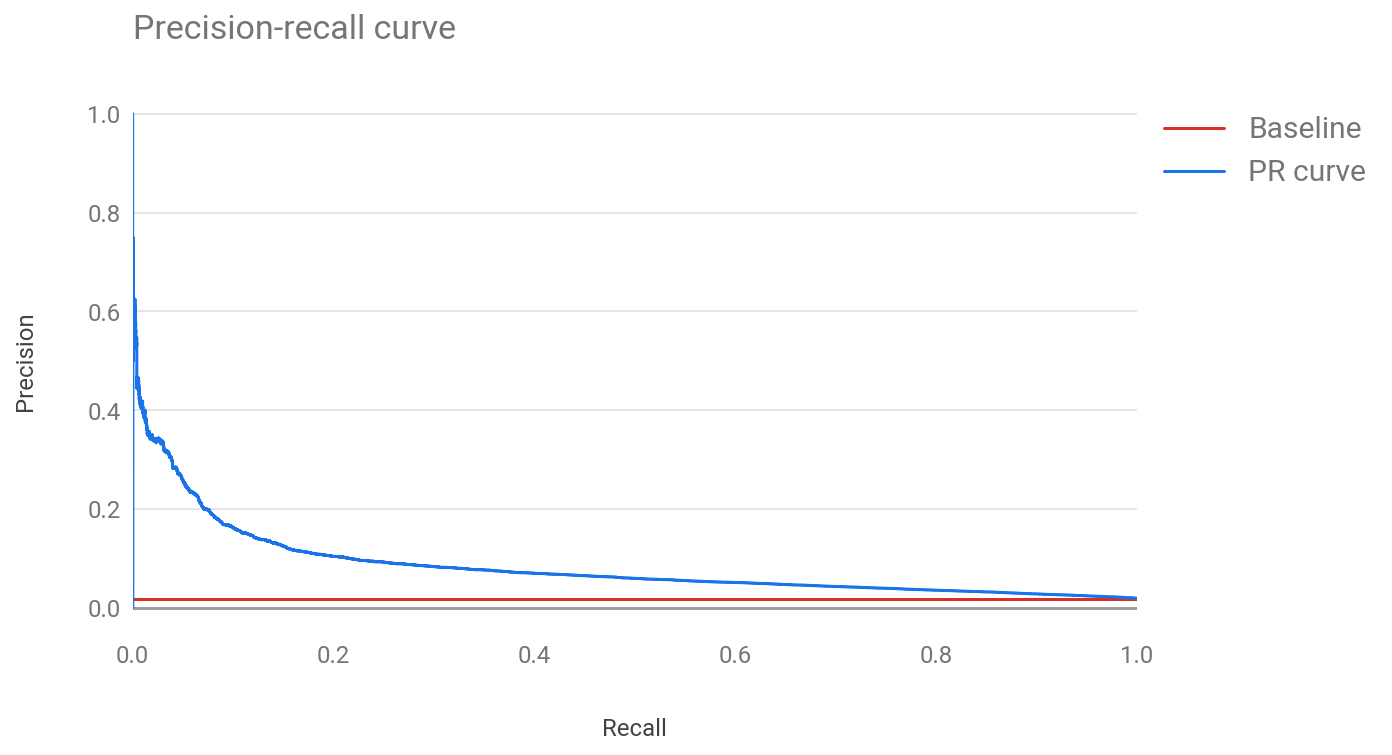

In [71]:
model_eval_plots.plot_pr(
    y_train["isFraud"], predict_proba, title="Precision-recall curve"
)

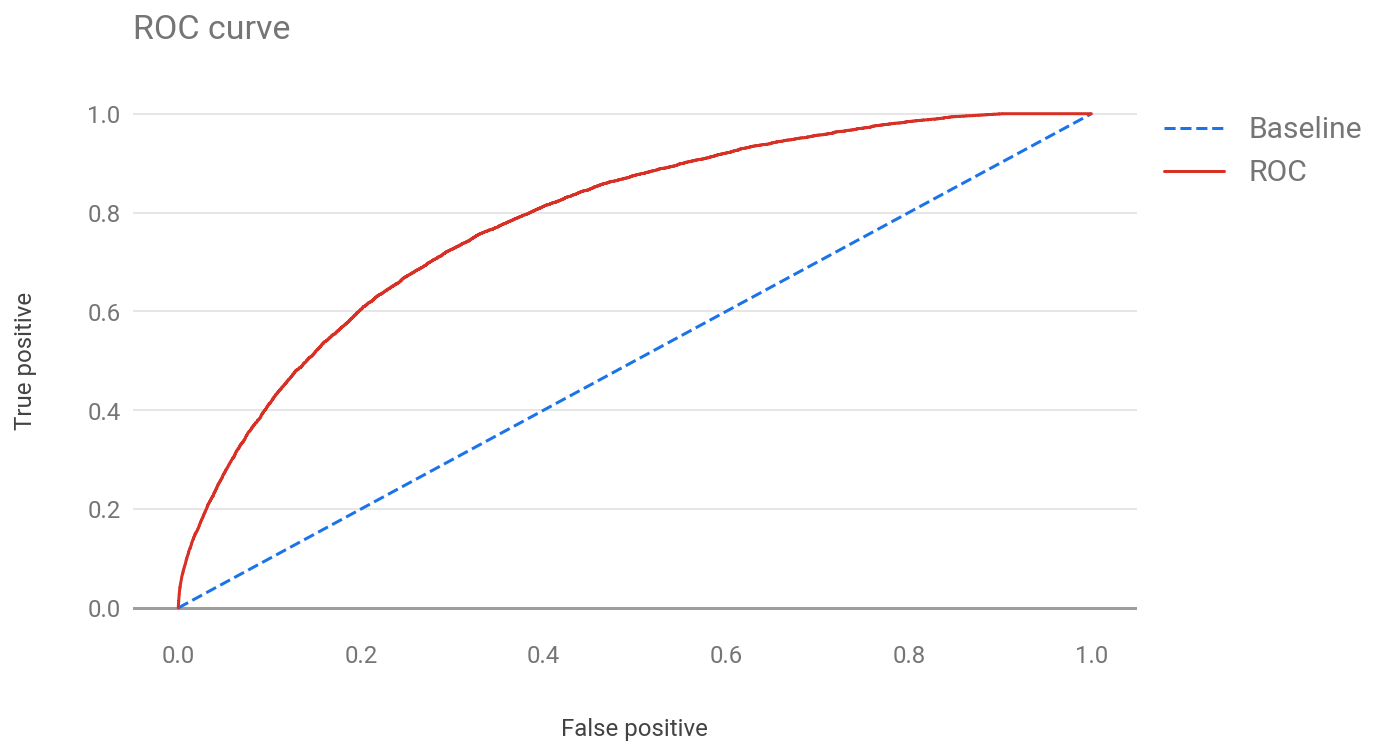

In [72]:
model_eval_plots.plot_roc(y_train["isFraud"], predict_proba, title="ROC curve")

The prediction probability distribution plot shows kernel density estimation of the model's predicted probabilities for transactions and colors them according to whether the transaction was fraudulent. Encouragingly, there is a clear distinction in the distribution of the predicted probabilities for the two classes, which means the model is effectively picking out signals that imply a fraudulent transaction. However, the two distributions have a large overlap, which means there is room to improve to help the model further separate the two classes. Interestingly, there is a sharp peak on the far left, indicating a group of transactions that the model is very sure are not fraudulent. It is worth clarifying that the areas under both curves are normalized to be equal, so even though fraudulent transactions are a fraction of the number of legitimate transactions, both peaks stand at about equal height.

The accompanying confusion matrix highlights that the model has a high amount of false positives, and could use some further work to help improve its precision.

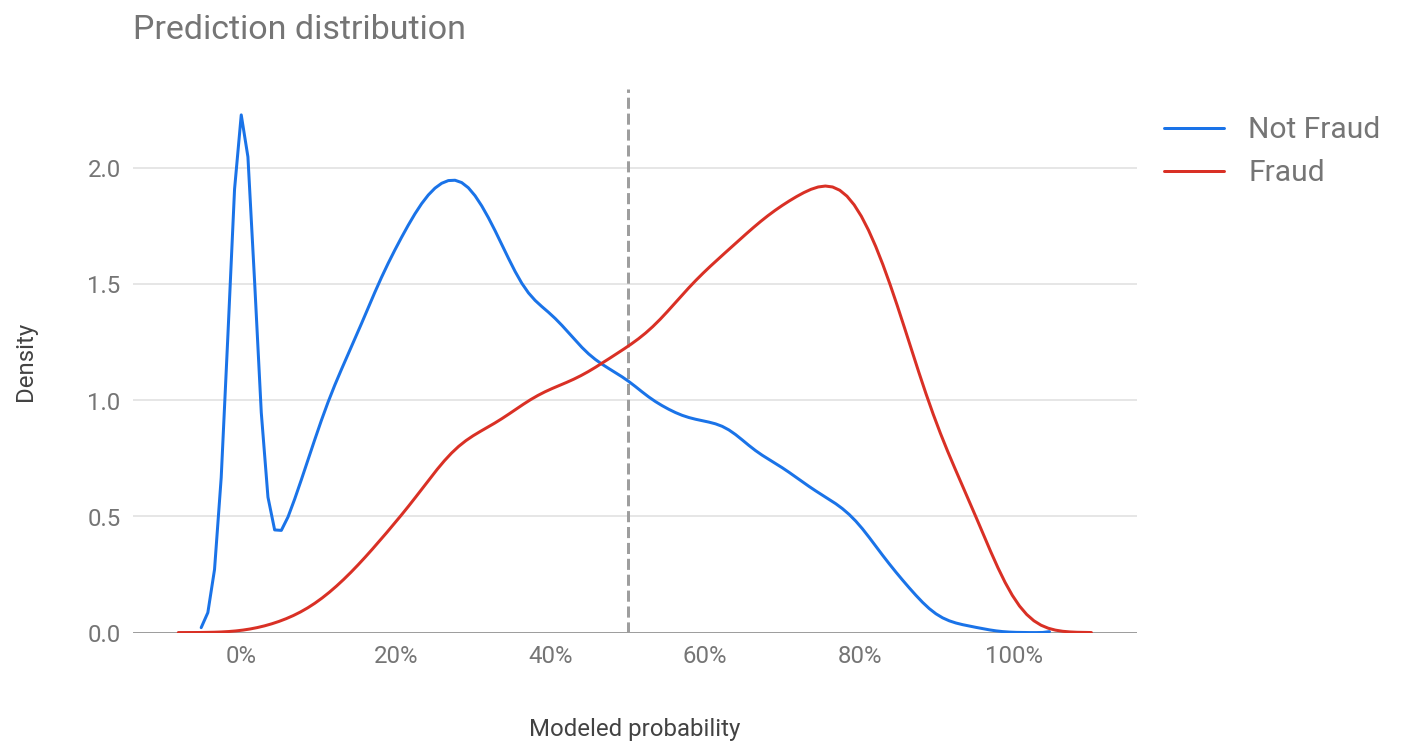

In [73]:
model_eval_plots.plot_probability_dist(
    y_train["isFraud"], predict_proba, title="Prediction distribution"
)

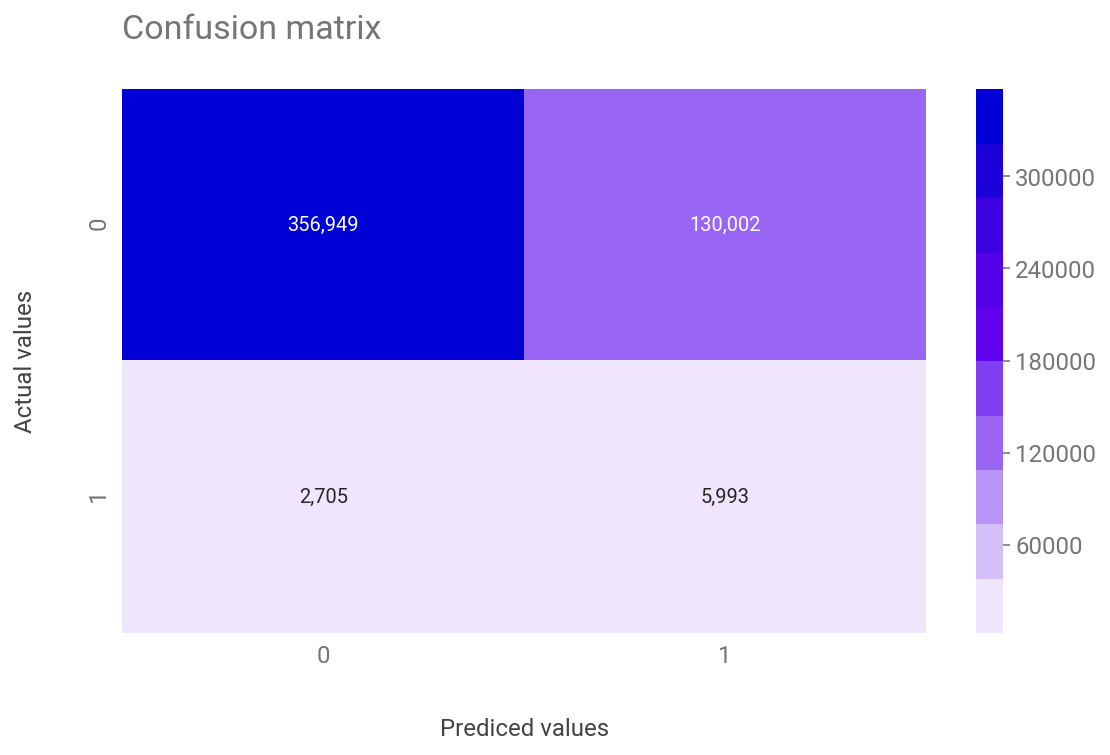

In [102]:
model_eval_plots.plot_confusion(
    y_train["isFraud"], predict_proba, title="Confusion matrix"
);

### Model analysis

To provide some intuition for the model, and inform what next steps should be taken to further improve its performance, Shapley values are calculated for the predictions.

The Shapley values reveal that `is_special_merchantCategoryCode` is highly influential feature. It was an engineered feature that indicated whether the transaction involved a fuel, mobileapps, online_subscription, food_delivery, gym, or cable/phone merchant. These categories were deemed unique because no multi-swipe or reversed transactions were detected in those transactions.

Additionally, it can be seen that the data lacks strong indicators of a fraudulent transaction. Only five of the top 20 features are shown to contribute positive Shapley values (meaning they push the prediction towards identifying the transaction as fraudulent). The `transactionAmount` was the biggest contributor—with high values making it more likely that the transaction is fraudulent.

An accompanying plot looks at the Shapley values just for `transactionAmount` reveals an interesting relationship with the feature `creditLimit`. When the `transactionAmount` is low the `creditLimit` being high will mean a lower chance of the model predicting the transaction to be fraudulent, while if the `transactionAmount` is high, a high `creditLimit` will result in the model predicting a higher chance of predicting fraud. The feature `creditLimit` interacts similarly with other features—as shown in other plots

The final feature to be highlighted is the Shapley values for the false negatives—the fraud the model missed out on. It can be seen that the `transactionAmount` for these false negatives is typically low. The model relies heavily on higher `transactionAmount` values for fraud detection, and needs improvement when dealing with lower transaction amounts.

In [75]:
# Train model for shap analysis since shap is not compatible with
# scikit-learn pipelines

# Using only the train data, make a stratified test train split for use
# in SHAP analysis
X_shap_train, X_shap_test, y_shap_train, y_shap_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit pipeline on SHAP train set
X_shap_train = data_prep_pipe.fit_transform(X_shap_train)
X_shap_test = data_prep_pipe.transform(X_shap_test)

# Oversample SHAP train
oversample = RandomOverSampler(random_state=42, sampling_strategy="minority")
X_shap_train, y_shap_train = oversample.fit_resample(
    X_shap_train, y_shap_train["isFraud"]
)

# Train model for shap analysis
clf_shap = XGBClassifier(
    n_jobs=-1, tree_method="hist", random_state=42, n_estimators=581
)
clf_shap.fit(X_shap_train, y_shap_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=581, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='hist', verbosity=1)

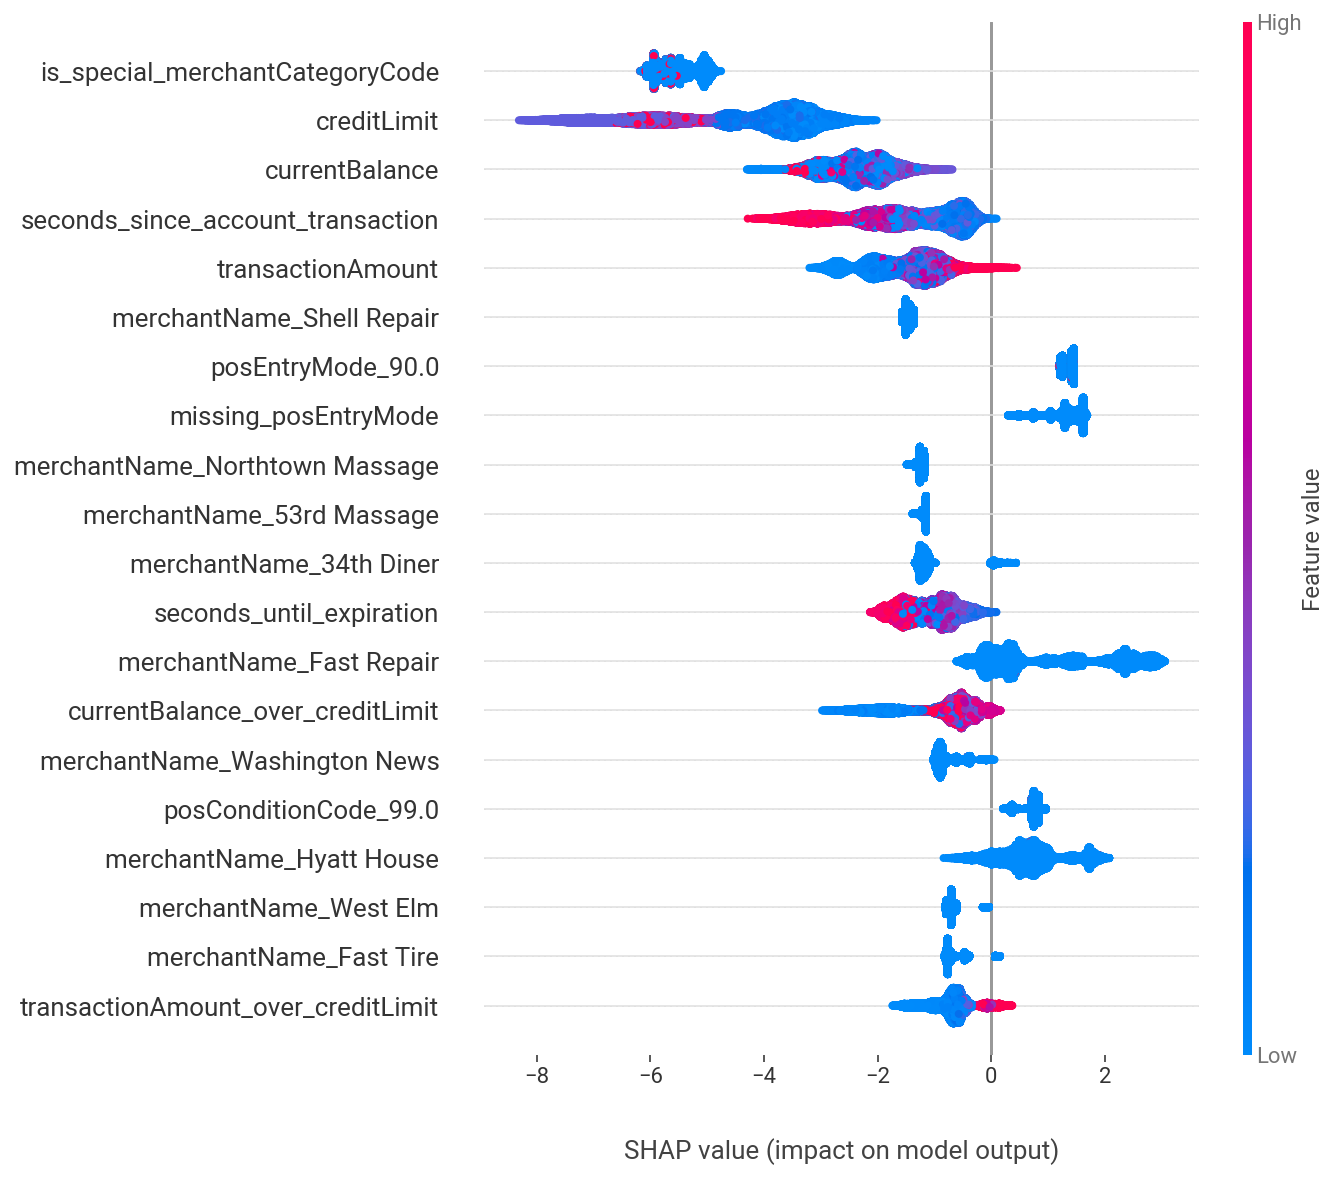

In [77]:
# Show SHAP plot
X_shap_test_df = pd.DataFrame(
    X_shap_test.todense(), columns=output_columns, index=[i for i in range(99130)]
)
explainer = shap.TreeExplainer(clf_shap)
shap_values = explainer.shap_values(X_shap_test_df)
shap.summary_plot(shap_values, X_shap_test_df)

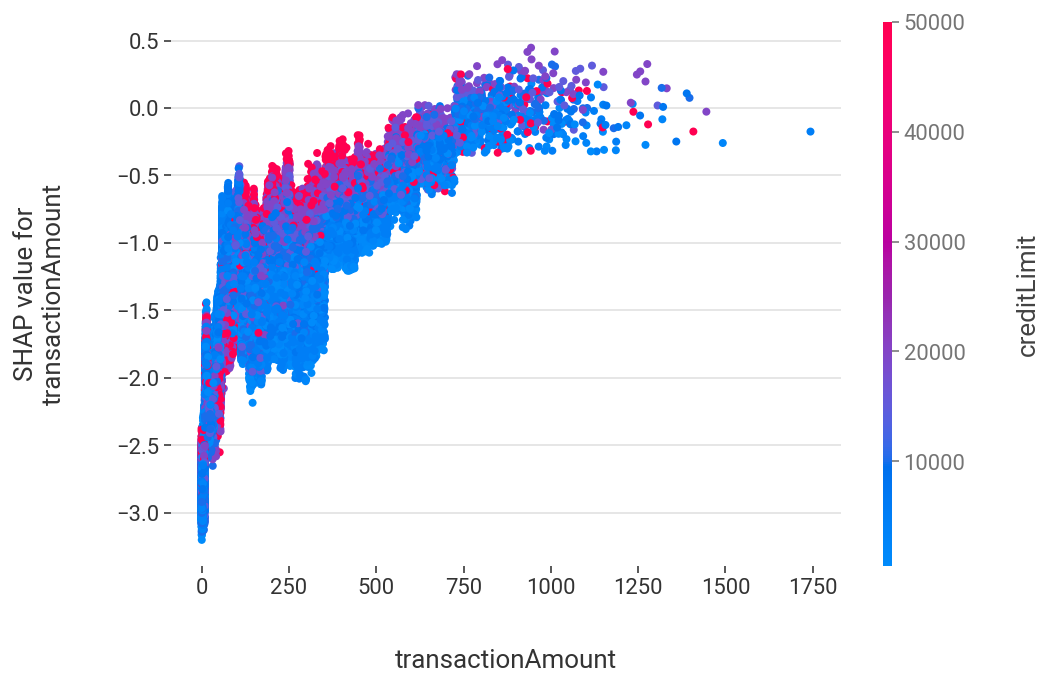

In [93]:
# Look at shap values for transactionAmount and it's relationship to
# creditLimit
shap.dependence_plot("transactionAmount", shap_values, X_shap_test_df)

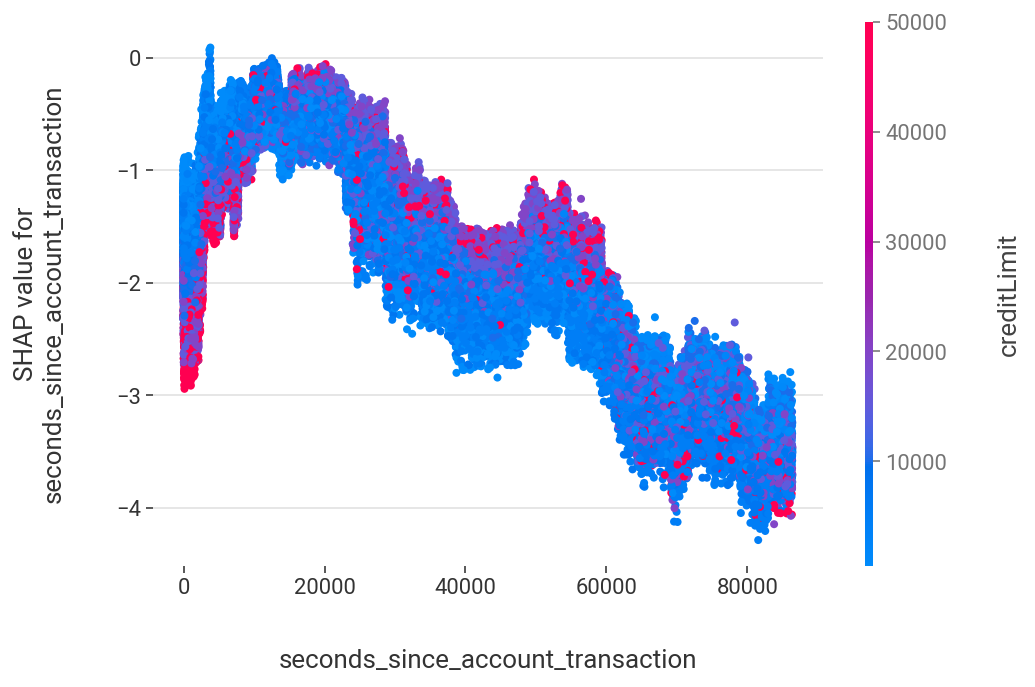

In [91]:
# Look at shap values for seconds_since_account_transaction and it's
# relationship to creditLimit
shap.dependence_plot("seconds_since_account_transaction", shap_values, X_shap_test_df)

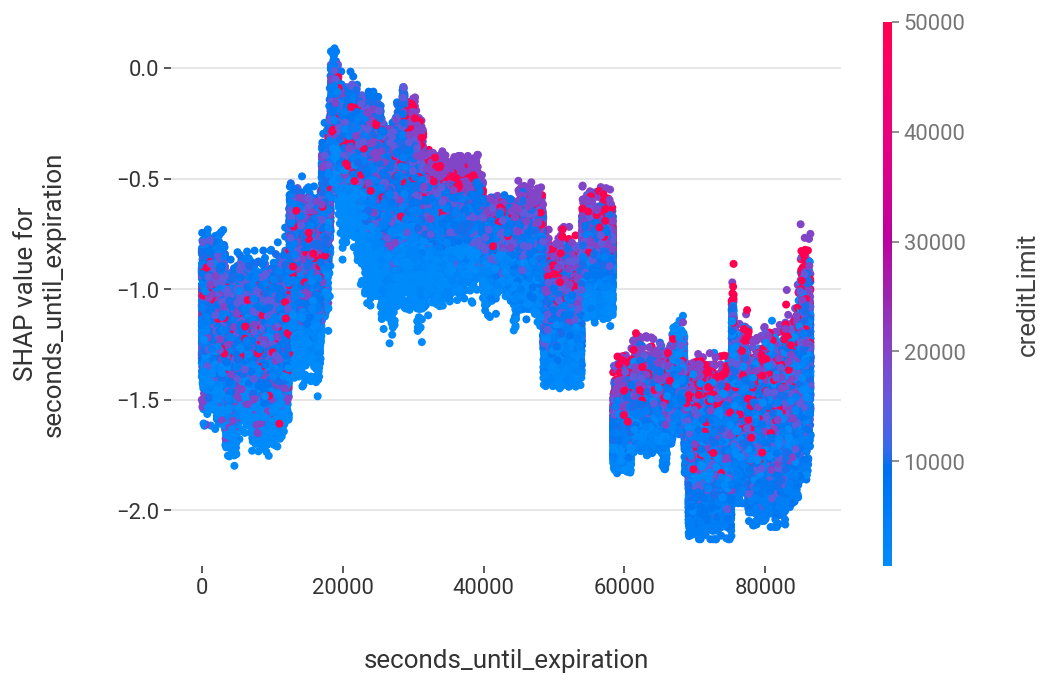

In [79]:
# Look at shap values for seconds_until_expiration and it's relationship
# to creditLimit
shap.dependence_plot("seconds_until_expiration", shap_values, X_shap_test_df)

In [80]:
# Output probabilities for model for shap analysis
y_predict_proba_shap = clf_shap.predict_proba(X_shap_test)

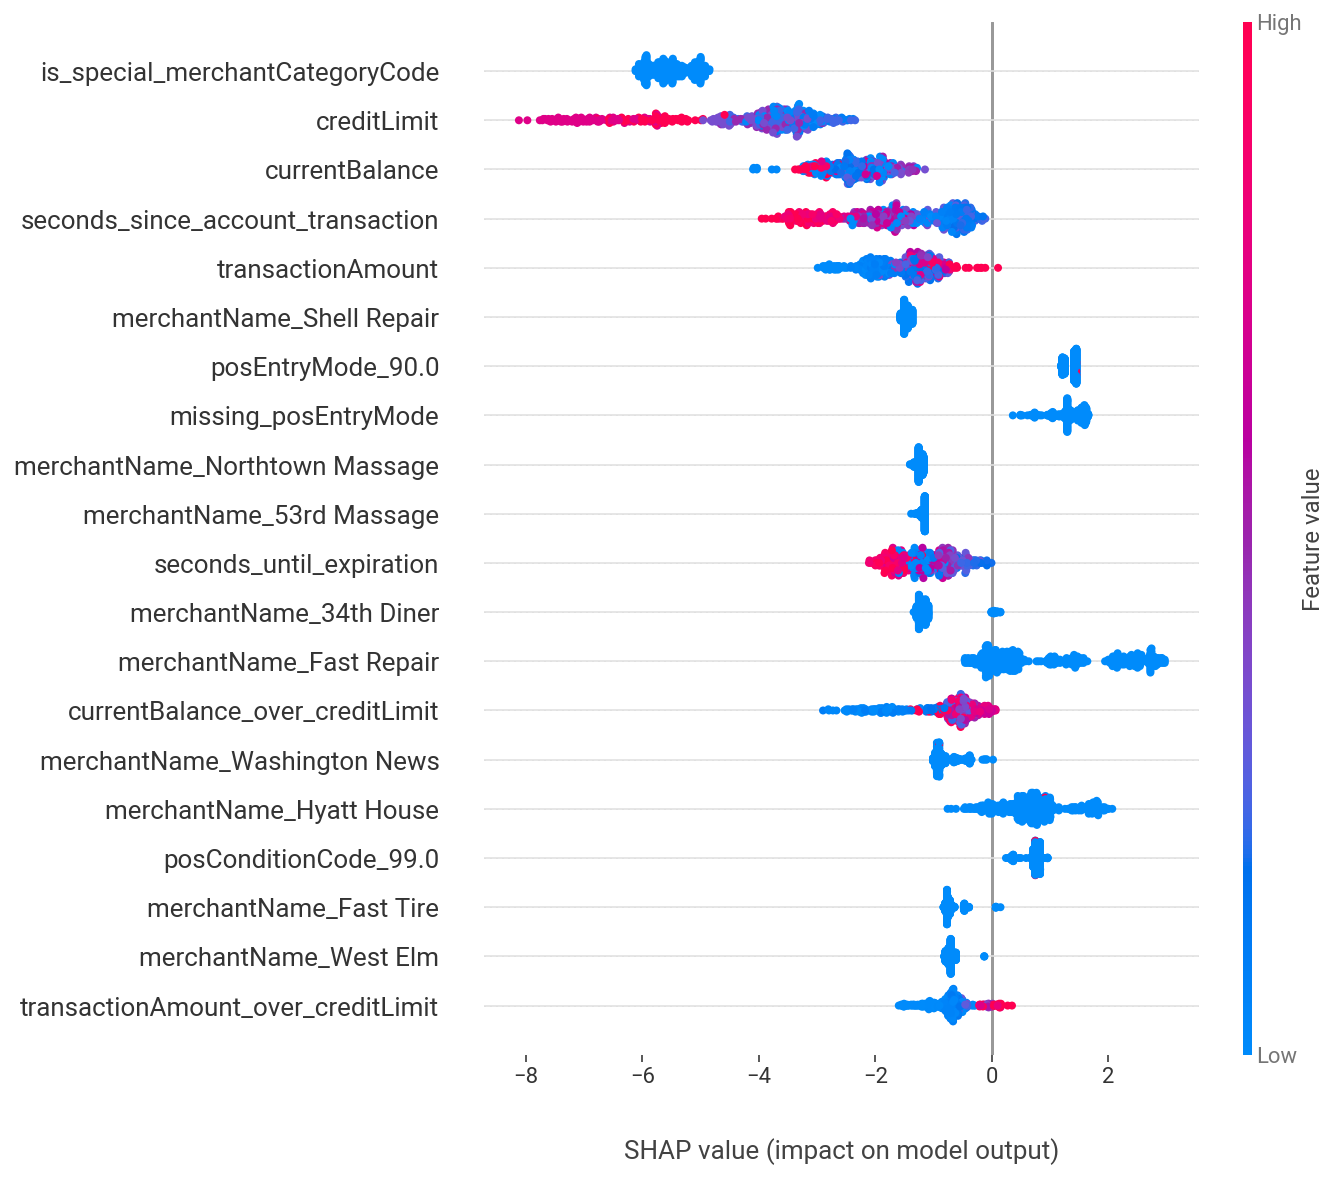

In [81]:
# Shap values for false negatives
false_negatives_filer = (
    (y_shap_test["isFraud"] == 1) & (y_predict_proba_shap[:, 1] < 0.5)
).values
shap.summary_plot(
    shap_values[false_negatives_filer], X_shap_test_df[false_negatives_filer]
)

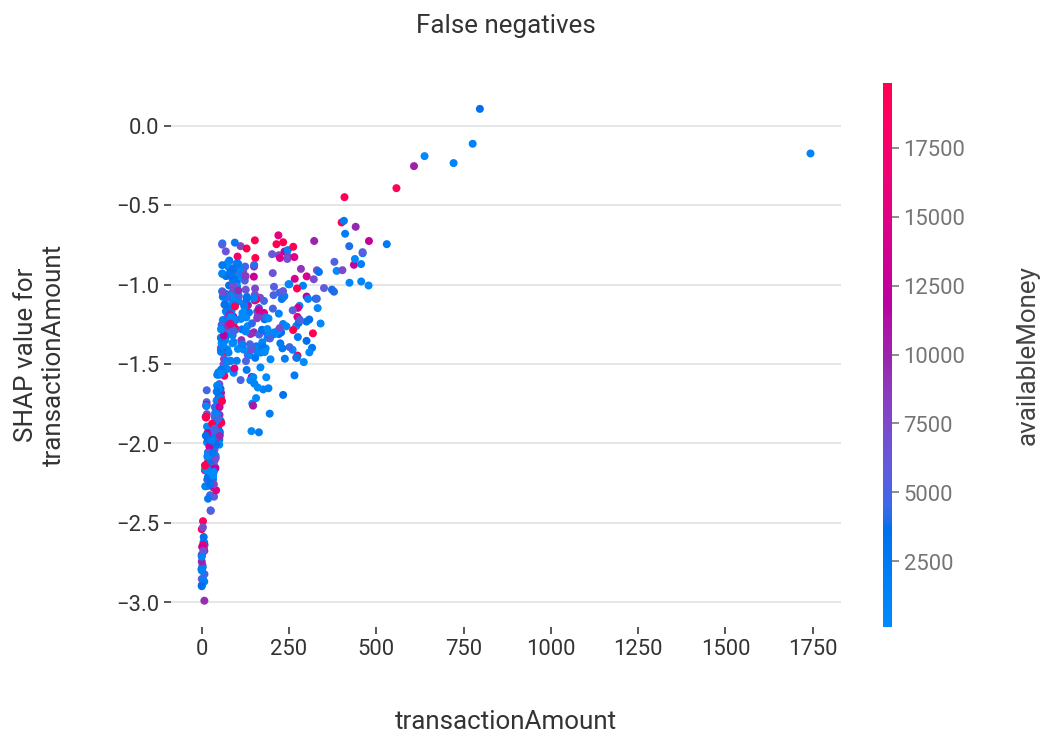

In [82]:
# Look at shap values for transactionAmount and it's relationship to
# seconds_since_account_transaction for false negative transactions
shap.dependence_plot(
    "transactionAmount",
    shap_values[false_negatives_filer],
    X_shap_test_df[false_negatives_filer],
    title="False negatives",
)

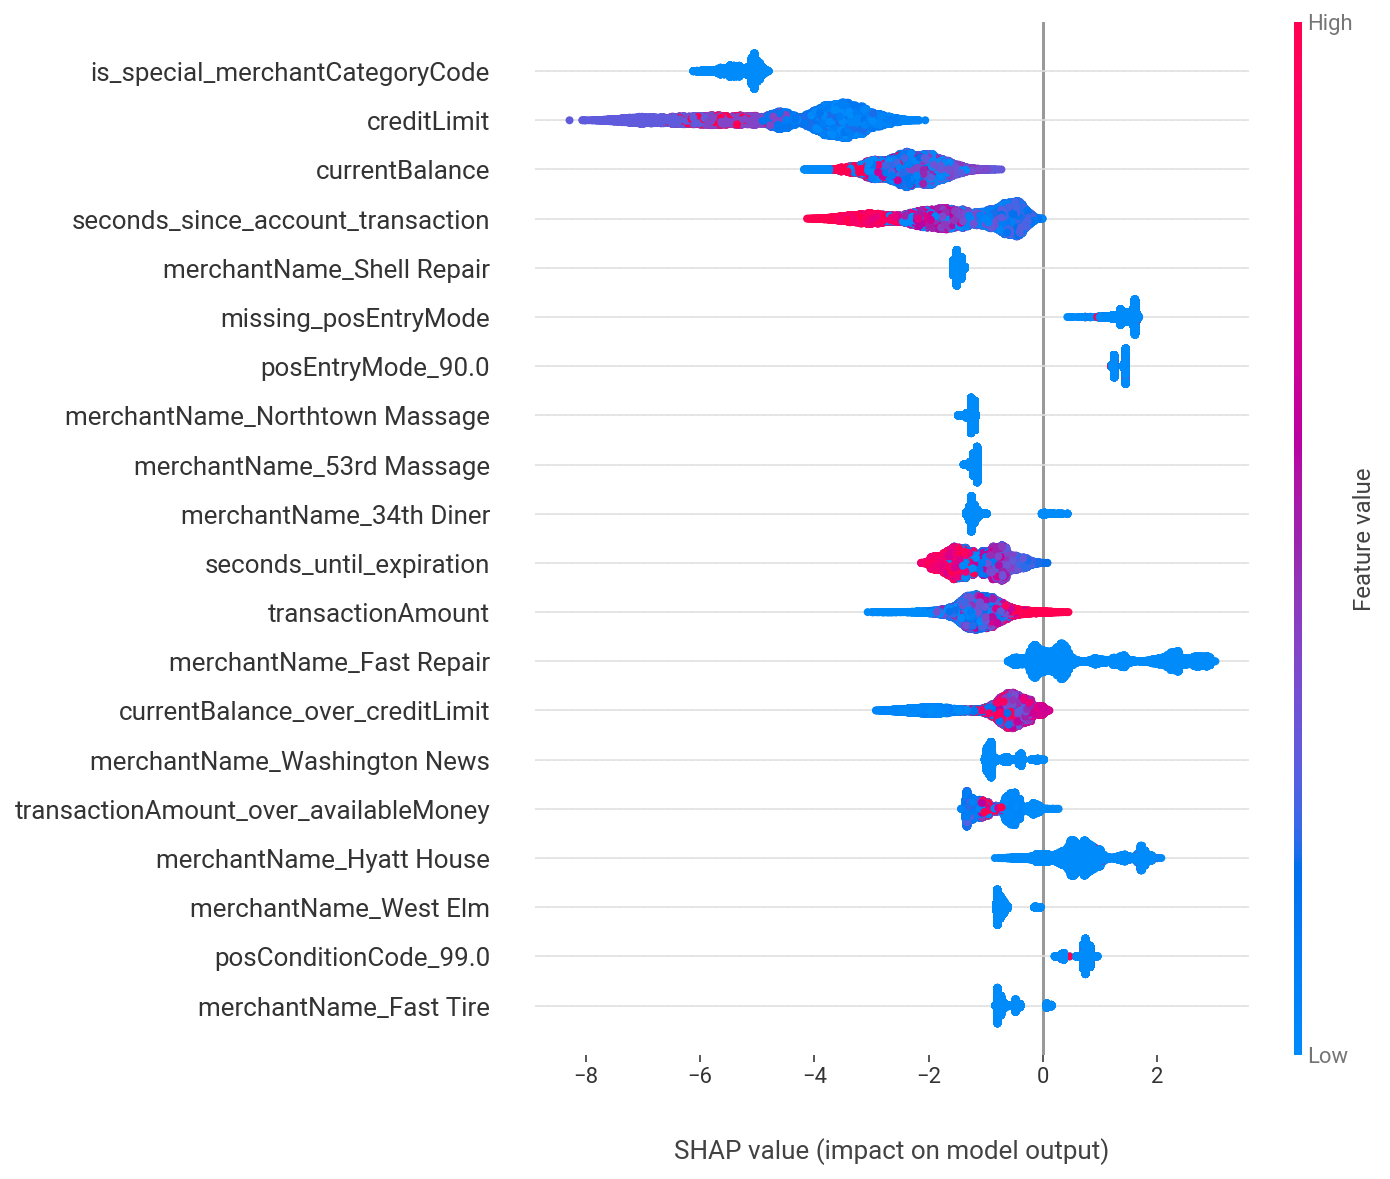

In [83]:
# Shap values for false positives
false_positives_filer = (
    (y_shap_test["isFraud"] == 0) & (y_predict_proba_shap[:, 1] > 0.5)
).values
shap.summary_plot(
    shap_values[false_positives_filer], X_shap_test_df[false_positives_filer]
)

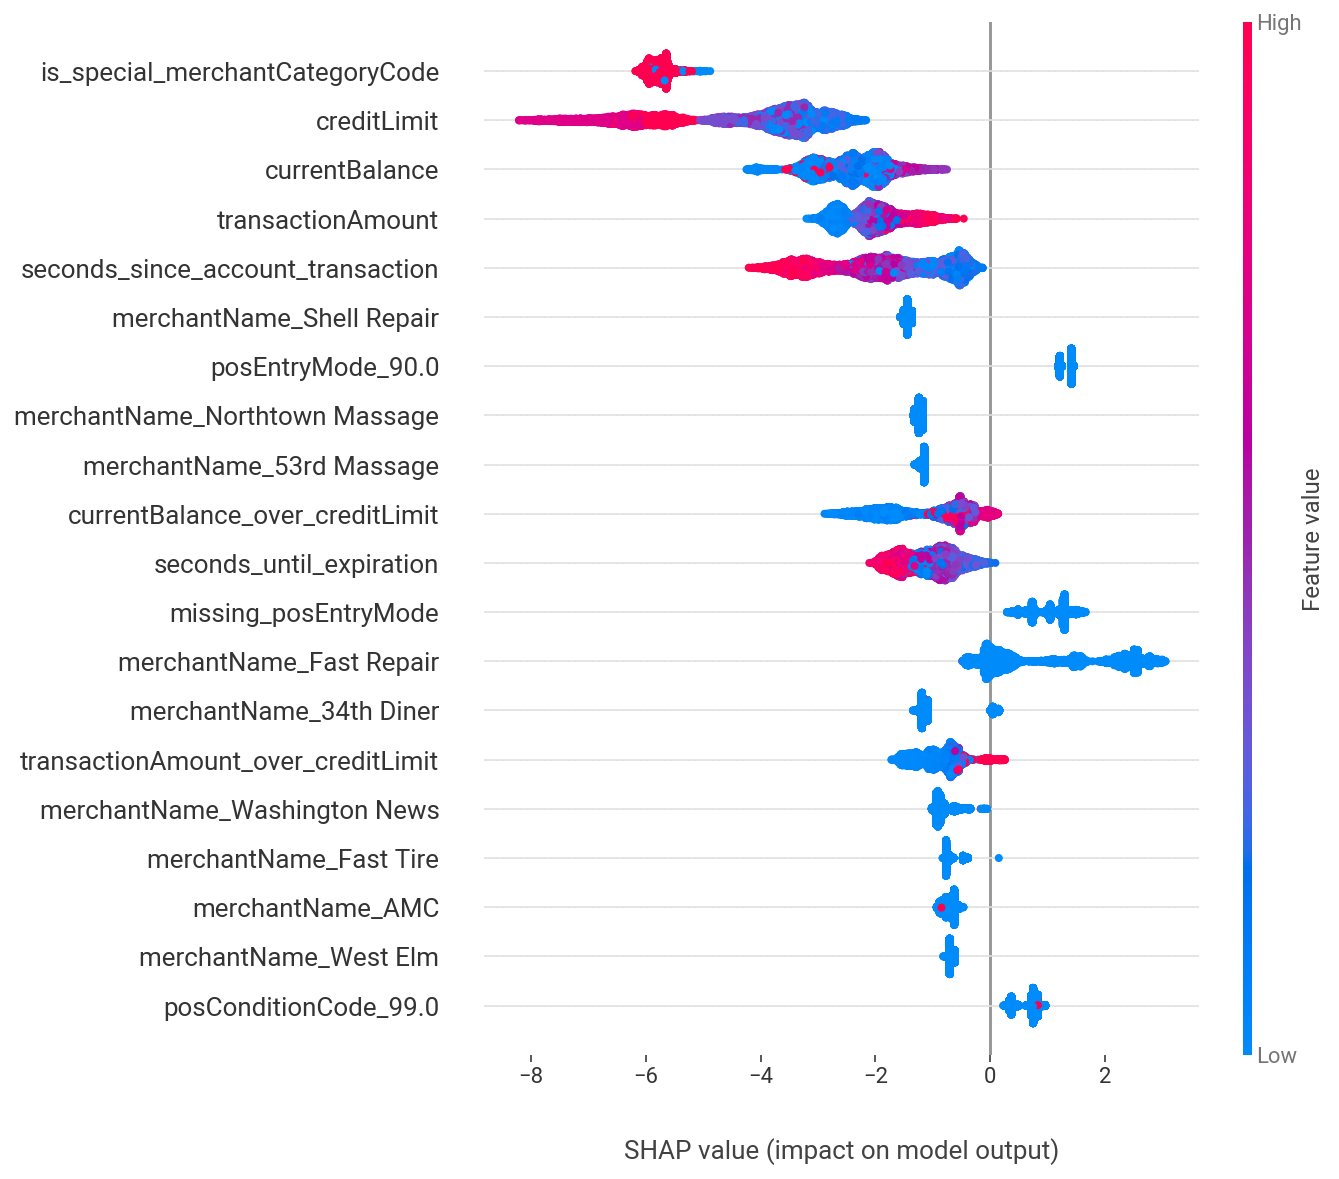

In [84]:
# Shap values for confident true negatives (probability of less than 5%)
false_negatives_filer = (
    (y_shap_test["isFraud"] == 0) & (y_predict_proba_shap[:, 1] < 0.05)
).values
shap.summary_plot(
    shap_values[false_negatives_filer], X_shap_test_df[false_negatives_filer]
)

### Future work

The model is off to a great start, but needs some improvement in distinguishing fraudulent transactions.

One obvious step I omitted is grid search to optimize hyperparameters. Similarly I would look at other models such as logistic regression, and other anomaly detection models such as Gaussian mixture models and compare their performance to the current gradient boosted tree implementation.

However, much more importantly, big gains in model performance are gained through data cleaning and feature engineering. Given the time and more computing power, I would engineer more features. Some of the features I would like to engineer are:

- Number of transactions in the last hour/day/week/all-time for account/customer
- Total transaction amount in the last hour/day/week/all-time for account/customer
- Most popular merchant category/name of account/customer
  - Does the transaction involve the most popular merchant category/name?
- Is the transaction at a new merchant category/name for the account/customer?
- Has the customer/account been a victim of fraud before?
  - Total amount of fraud incidents for account/customer
- Average number of transactions per day/week for customer/account
- Average transaction amount per day/week for customer/account
- Holidays for different countries (only used US federal holidays)

When filling out the missing values for the columns "posEntryMode" and "posConditionCode" I simply filled them in with their most popular values. This is rarely the optimal method. If given more time I would search the data for a relationship with other values as done with other columns, find the most popular values for cohorts of transactions (the most popular "posEntryMode" per "transactionAmount" bin, etc.), or use a k-nearest neighbors model to more intelligently fill in missing values. I had lookup up some basic definitions for the two columns—"posEntryMode" identifies the method used to capture the account number, and "posConditionCode" identifies transaction conditions—but confidently knowing exactly what each code stood for would help in both filling values, feature engineering, and interpreting model Shapley values.

Additionally, when identifying multi-swipe and reversed transactions, I semi-arbitrarily chose 12 hours as the time window for seeking out these duplicate transactions. I know this led to some possible duplicate transactions being cut out. I would like to consult with a subject matter expect to tune this window appropriately.
